In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
data = pd.read_csv("data.csv", index_col=0)
min_value = data.iloc[:, 5:].min().min()
data = data.fillna(min_value - 1)
data.iloc[:, 5:] = data.iloc[:, 5:] + (min_value - 1)*(-1)

In [3]:
name_mac_relation = pd.read_csv("mac_name_relation.csv", index_col=0)
good_aps = name_mac_relation[name_mac_relation['ap_name'].isin( ["Guest-CentraleSupelec", "eduroam", 'stop&go', 'CD91', 'fabrique2024'])]["ap_mac"].to_list()
columns_to_maintain  = good_aps + data.columns[:5].to_list()
data = data[data.columns.intersection(columns_to_maintain)]

In [4]:
AP_columns = list(data.columns[5:])
data = data[data["room_part"] != 5]

In [5]:
non_AP_columns = list(data.columns[:5])


# Plots

In [39]:
data["room"].unique()

array(['LC410', 'LC412', 'LC414', 'LC416', 'LC415', 'LC437', 'LC442',
       'LC443', 'LC448', 'LC426', 'LC424', 'LC455', 'LC417', 'LC413'],
      dtype=object)

In [40]:
room = "LC415"
data_of_room_part = data[(data["room"] == room)]
data_of_room_part = data_of_room_part.sort_values(by='timestamp')
data_of_room_part = data_of_room_part.reset_index()


In [22]:
aps_to_plot = ['94:d4:69:f9:7d:6b:', '94:d4:69:f9:5b:e6:', '94:d4:69:fd:b1:e8:',
 '94:d4:69:f9:7f:cb:',
 '94:d4:69:f9:7e:4c:',
 '94:d4:69:fd:ac:e8:',
 '94:d4:69:f9:7d:c4:', '94:d4:69:fa:94:4b:',  '94:d4:69:fd:ae:c4:', '94:d4:69:f9:7d:67:',
 '94:d4:69:fd:b1:07:', '94:d4:69:f6:ed:cb:', '94:d4:69:f6:c8:86:', 
 '94:d4:69:fa:94:48:', '94:d4:69:fd:b1:e0:', '94:d4:69:fd:b1:ef:', '94:d4:69:f6:e4:e0:', '94:d4:69:fd:b2:28:',
 '70:d3:79:2e:ba:03:', '94:d4:69:fd:b1:09:'
   ]

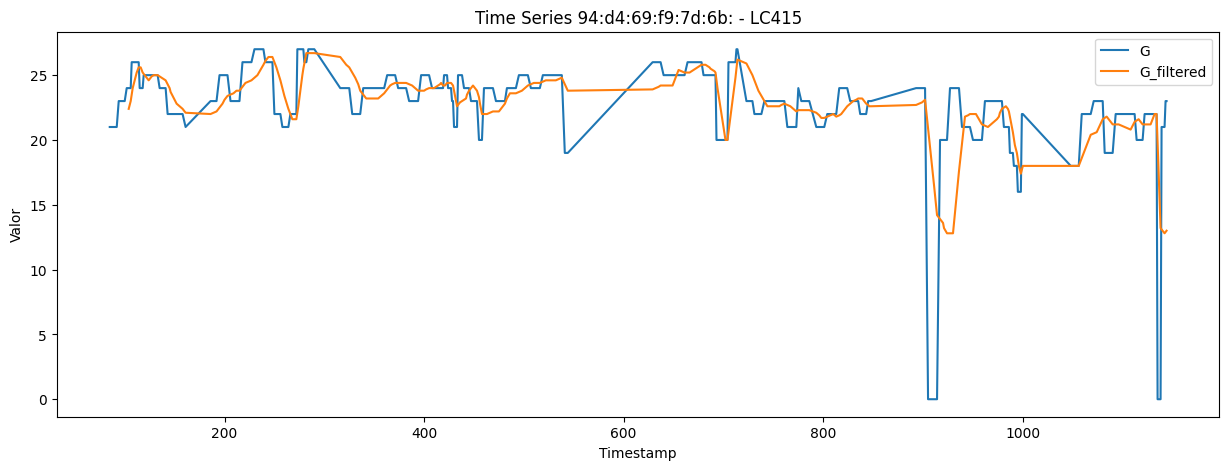

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(data_of_room_part[data_of_room_part["device_id"] == "G"].index,
            data_of_room_part[data_of_room_part["device_id"] == "G"]["94:d4:69:f9:7d:6b:"], label="G")

plt.plot(data_of_room_part[data_of_room_part["device_id"] == "G"].index,
            data_of_room_part[data_of_room_part["device_id"] == "G"]["94:d4:69:f9:7d:6b:"].rolling(window=10).mean(), label="G_filtered")

plt.xlabel('Timestamp')
plt.ylabel('Valor')
plt.title(f'Time Series {"94:d4:69:f9:7d:6b:"} - {room}')
plt.legend()
plt.show()

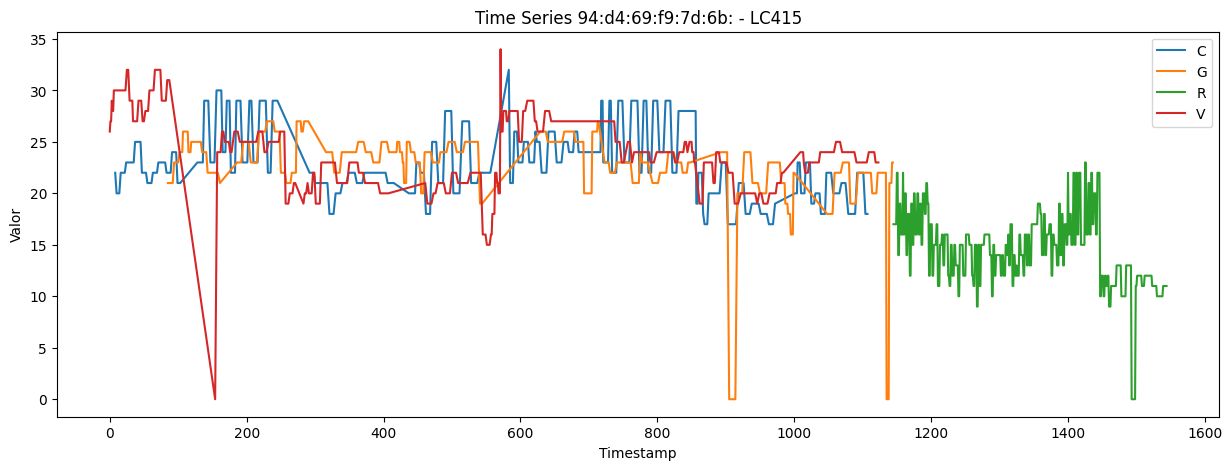

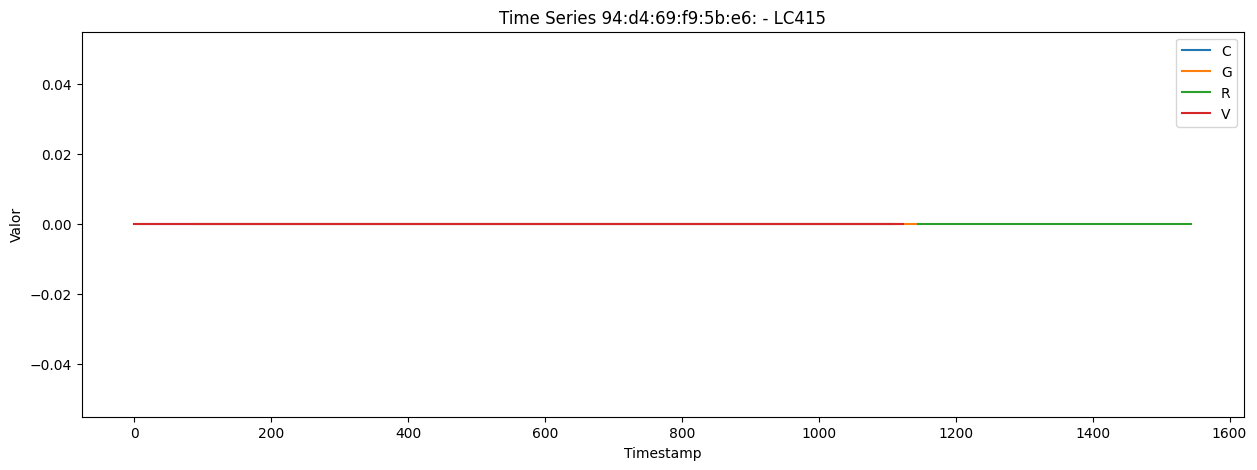

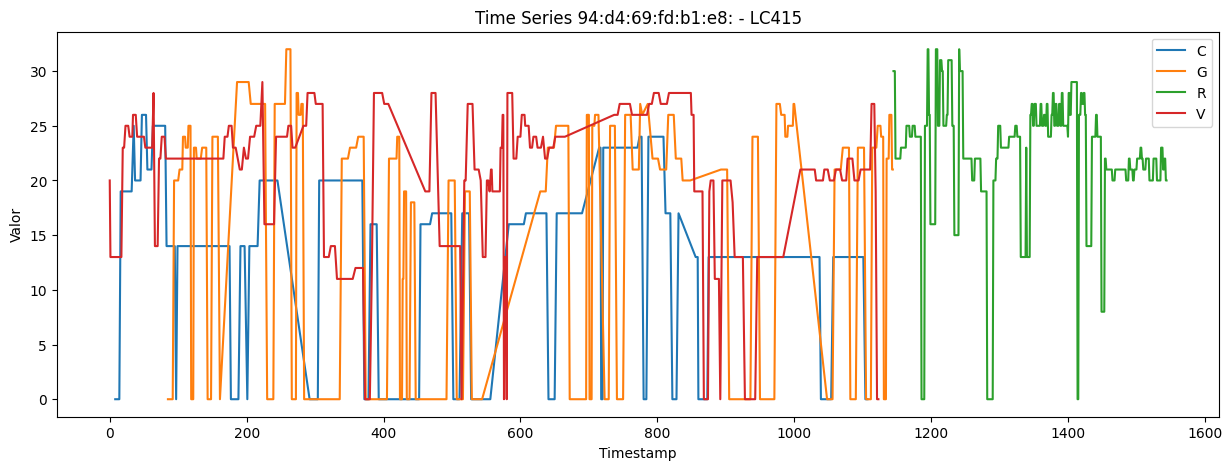

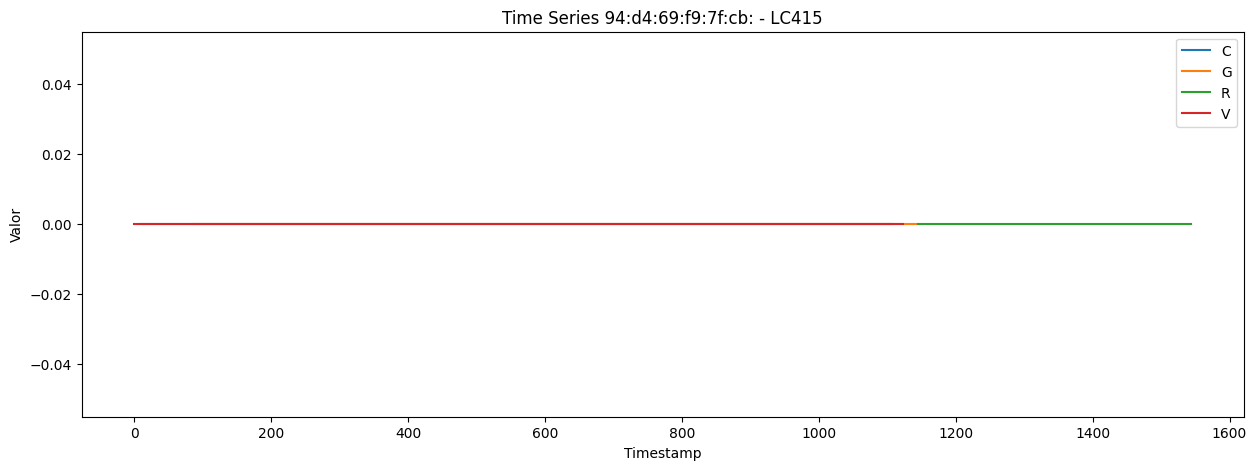

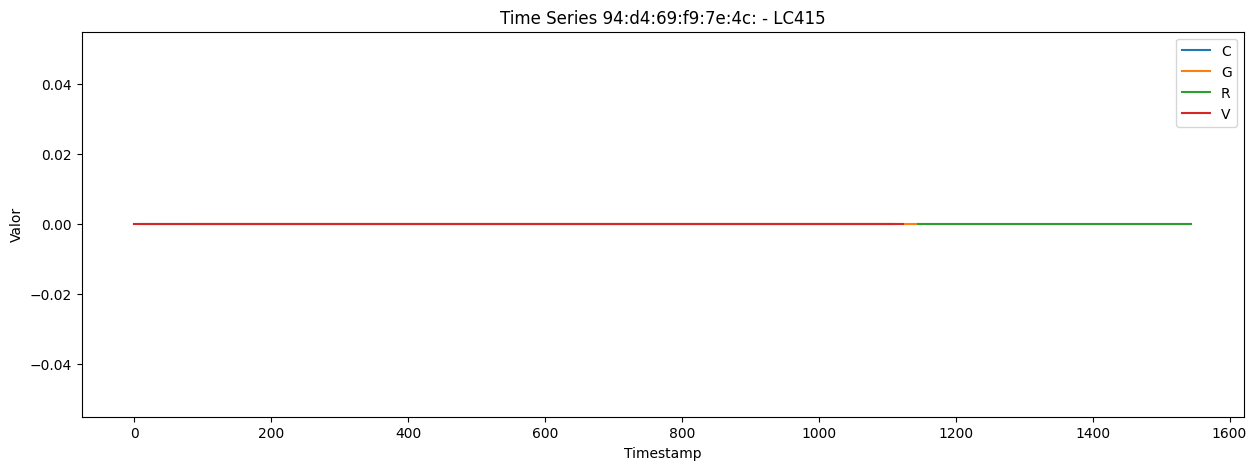

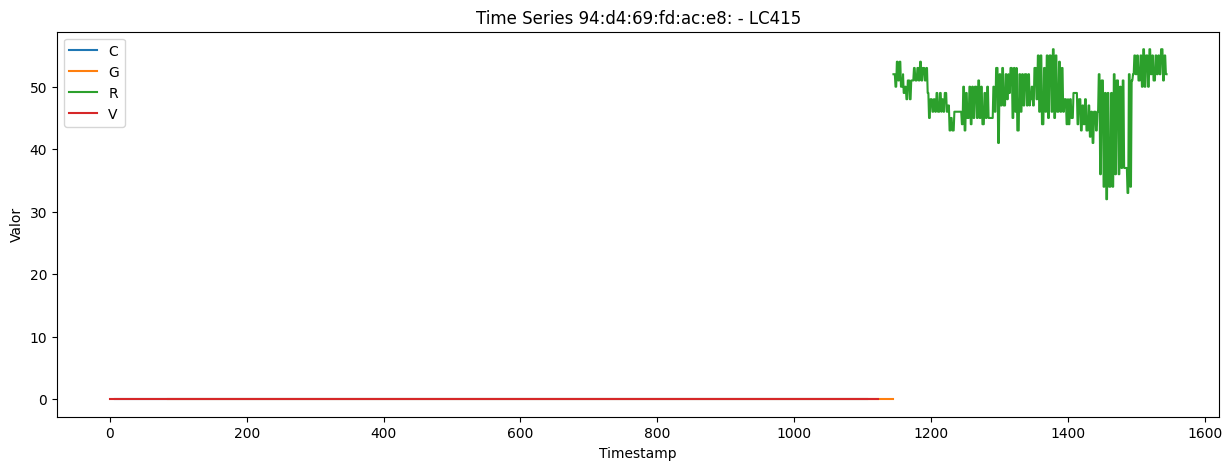

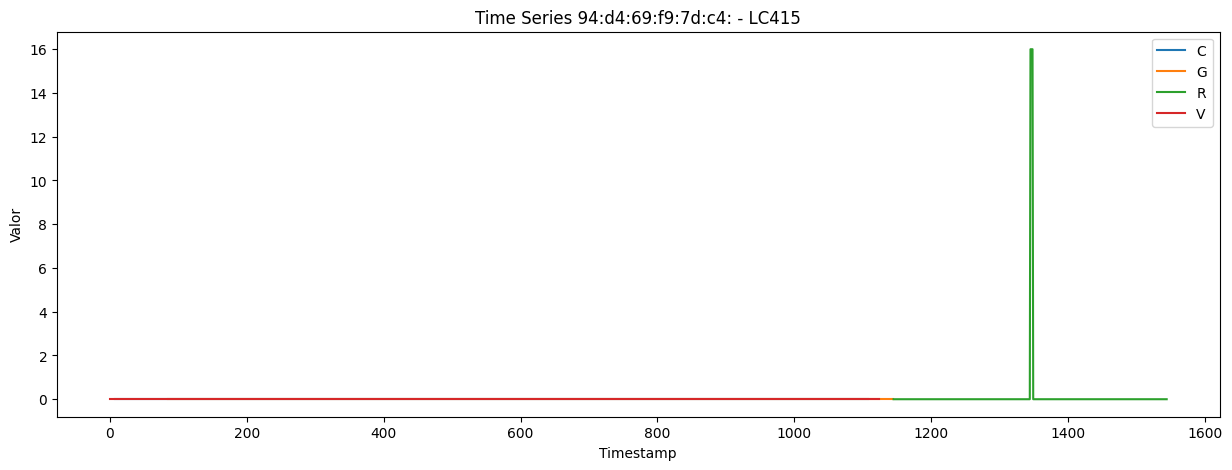

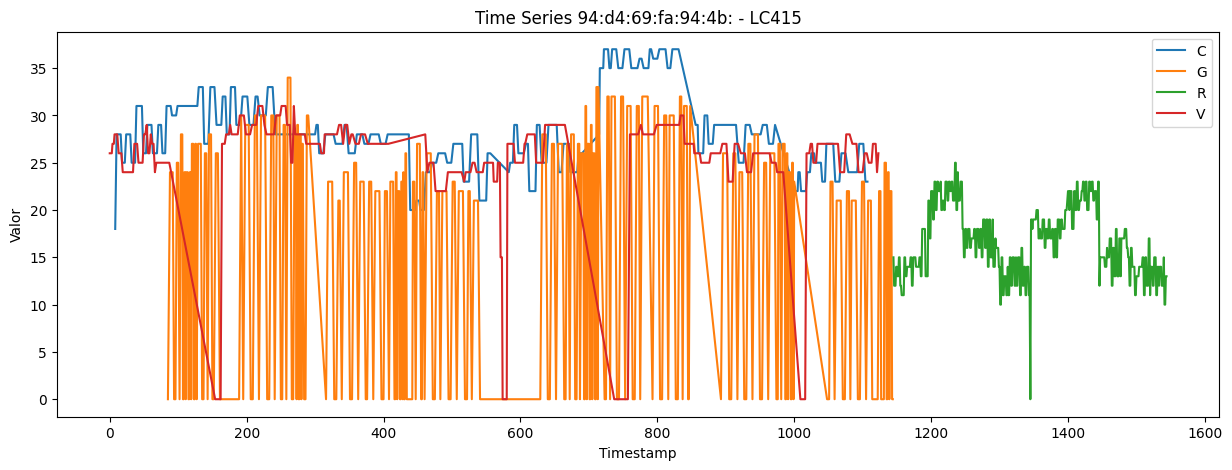

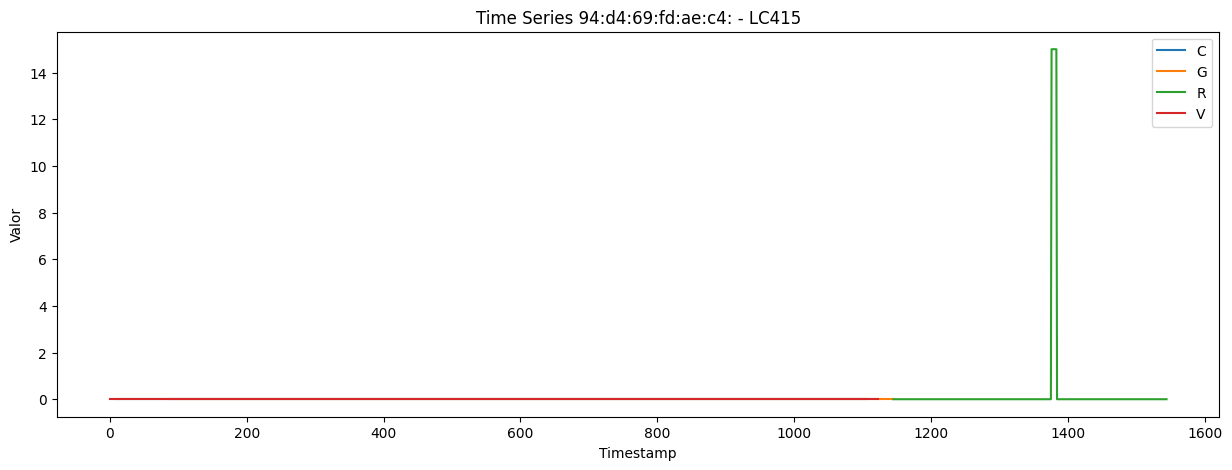

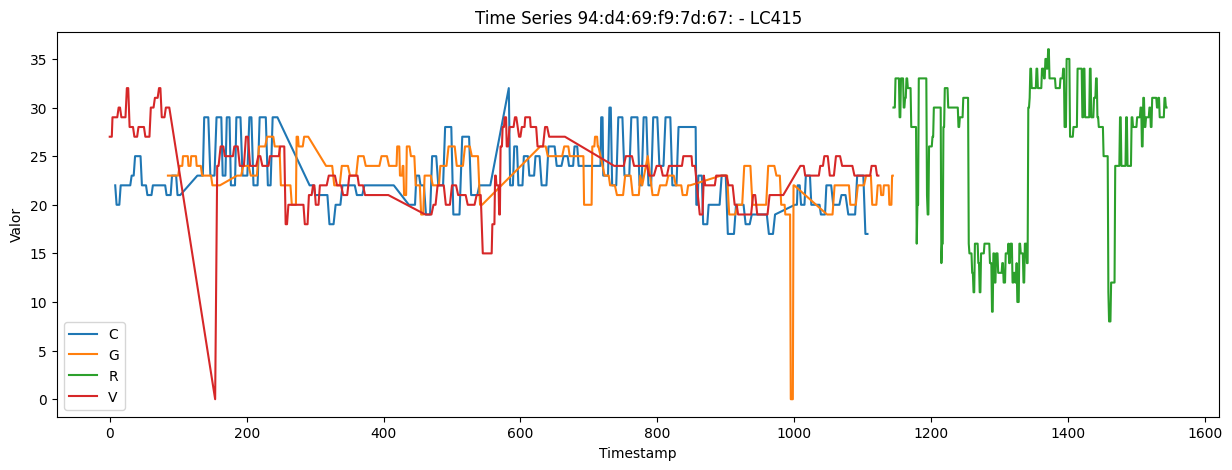

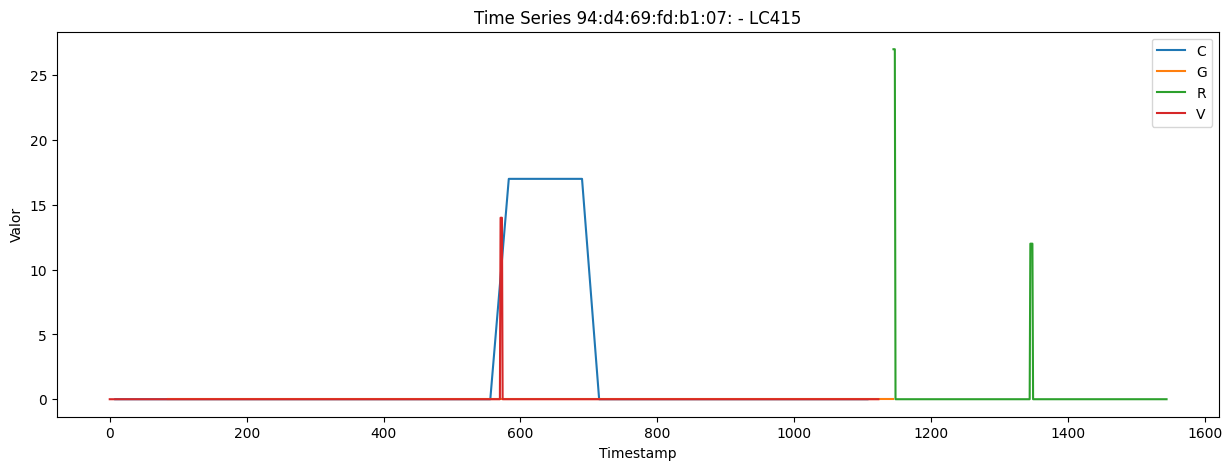

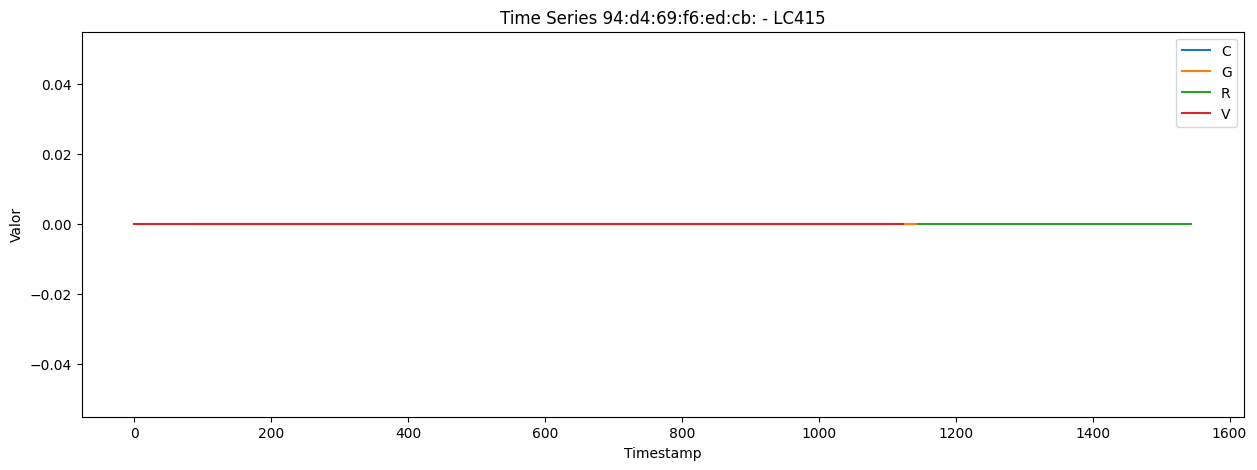

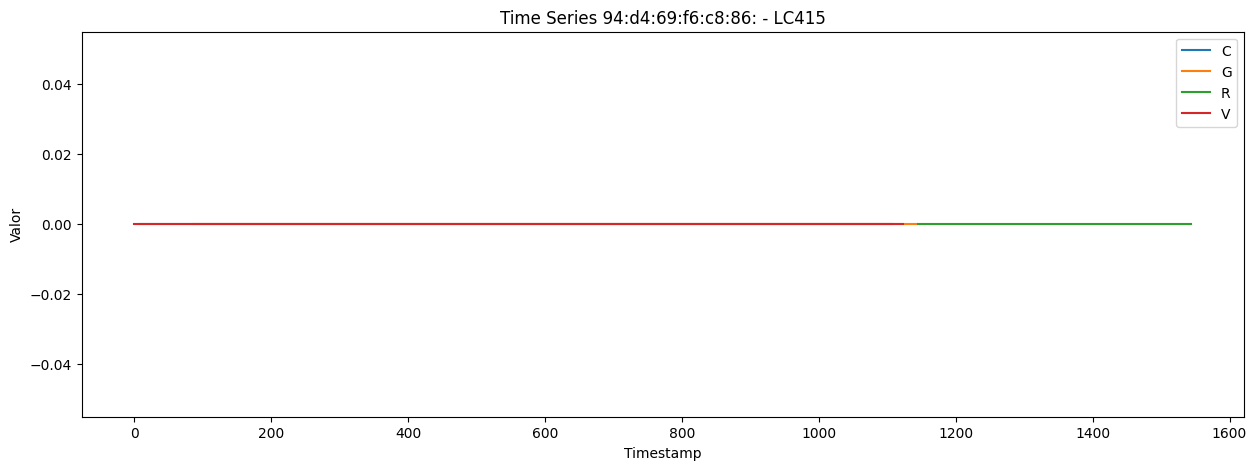

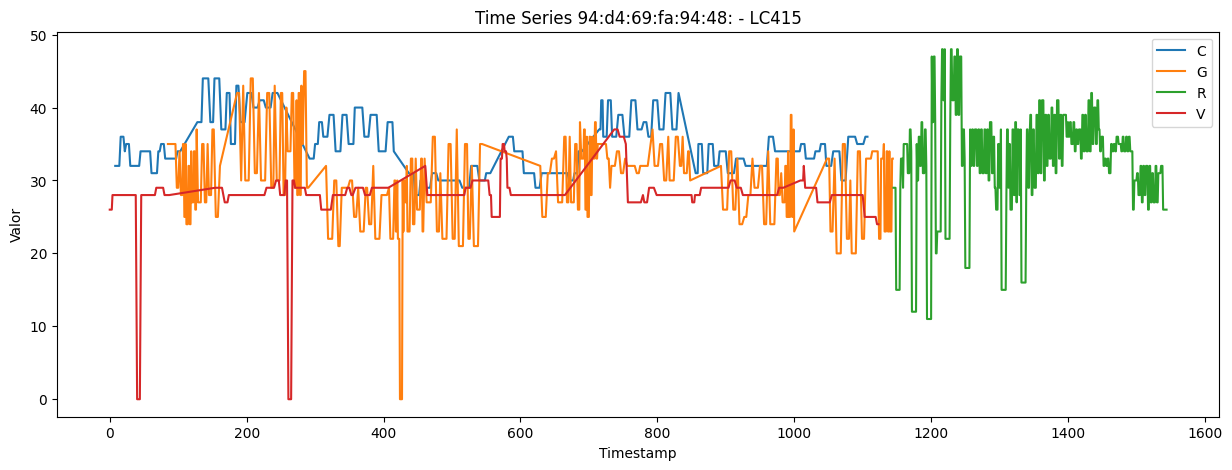

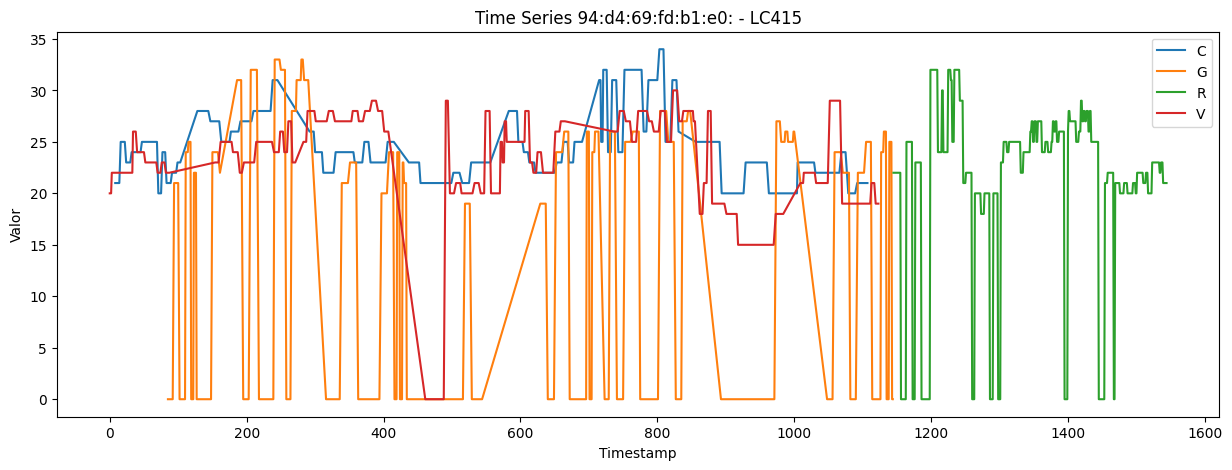

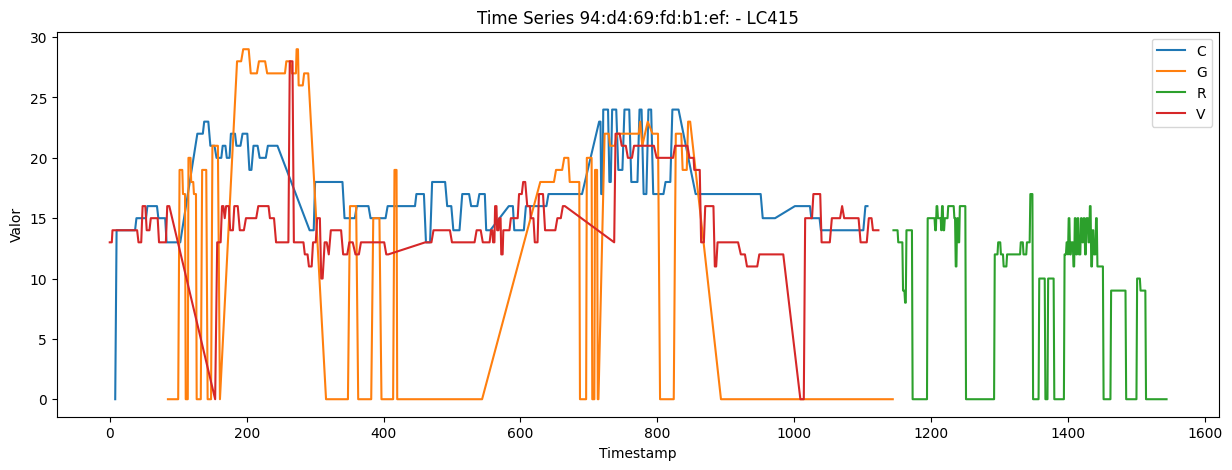

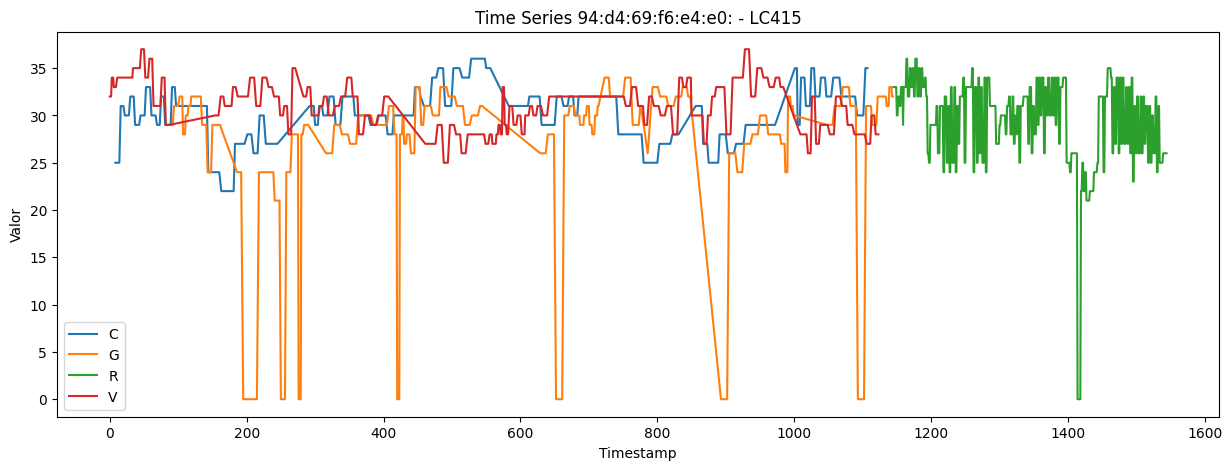

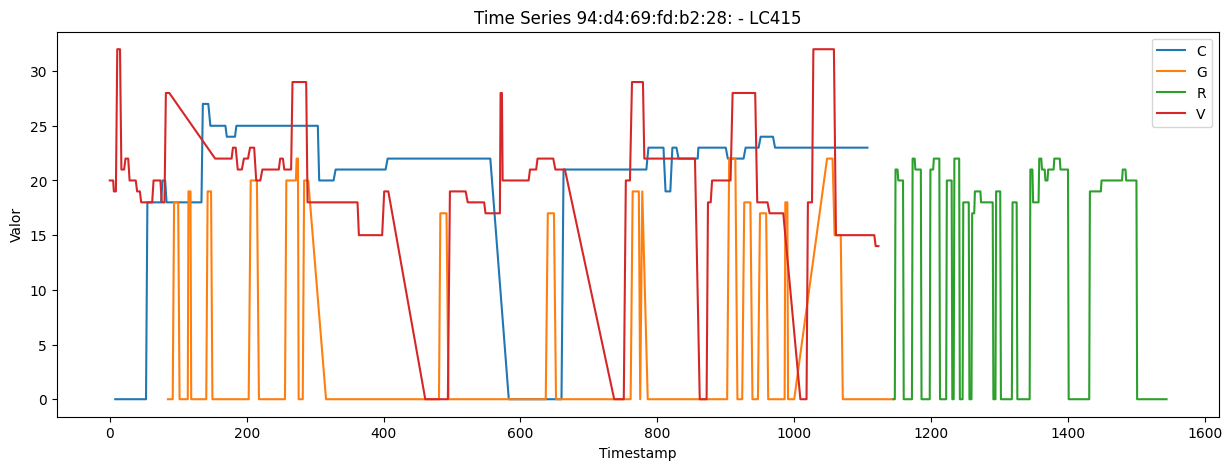

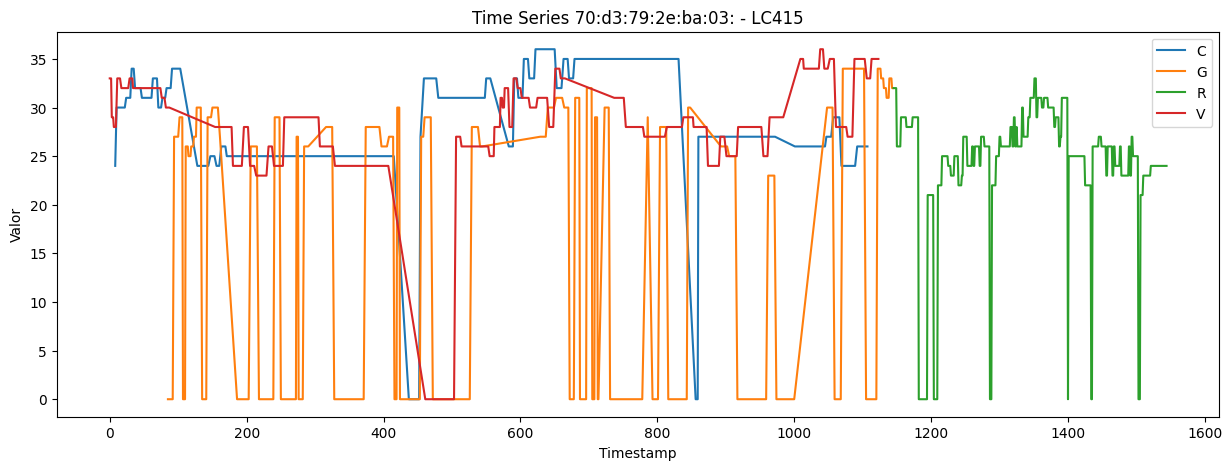

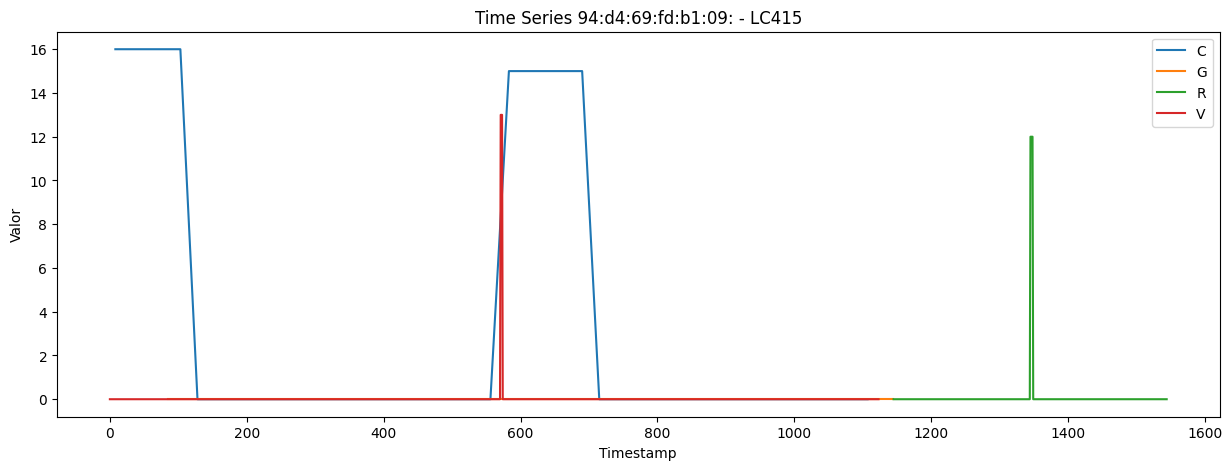

In [42]:


for AP in aps_to_plot:
    plt.figure(figsize=(15, 5))
    for label in np.unique(data_of_room_part["device_id"]):
        plt.plot(data_of_room_part[data_of_room_part["device_id"] == label].index,
                data_of_room_part[data_of_room_part["device_id"] == label][AP], label=label)

    plt.xlabel('Timestamp')
    plt.ylabel('Valor')
    plt.title(f'Time Series {AP} - {room}')
    plt.legend()
    plt.show()

        


In [29]:
rooms = list(data["room"].unique()) 


In [35]:
# AP = "94:d4:69:fa:94:4b:"
AP = "94:d4:69:f9:7d:c4:"
data_of_ap = data[["room", "device_id", AP, "timestamp"]]
data_of_ap = data_of_ap.sort_values(by='timestamp')
data_of_ap = data_of_ap.reset_index()

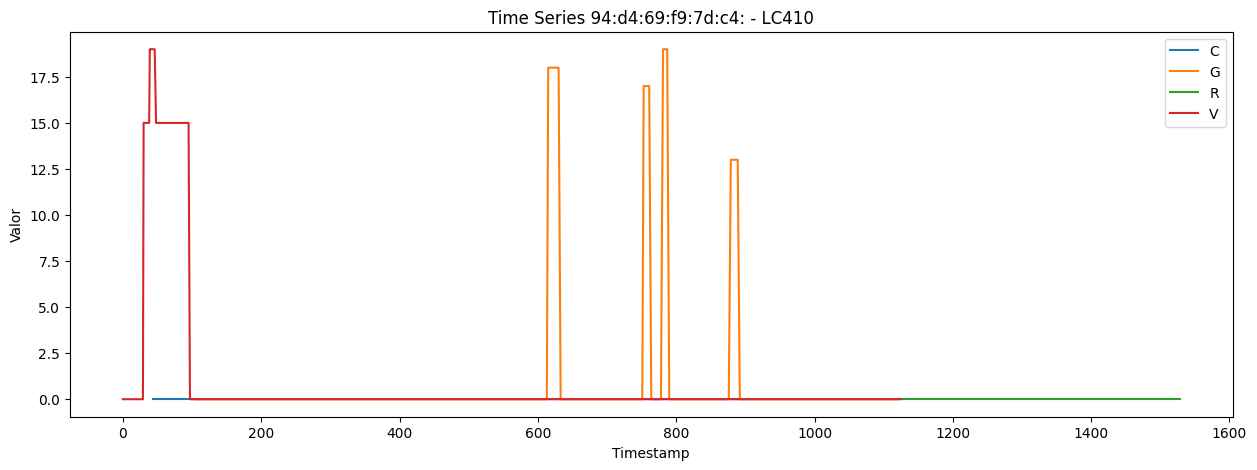

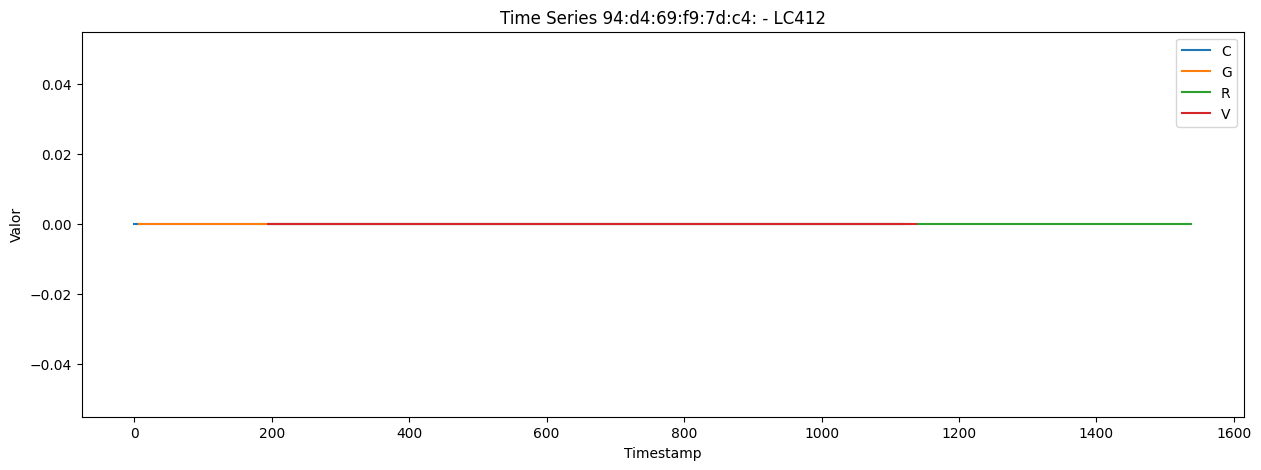

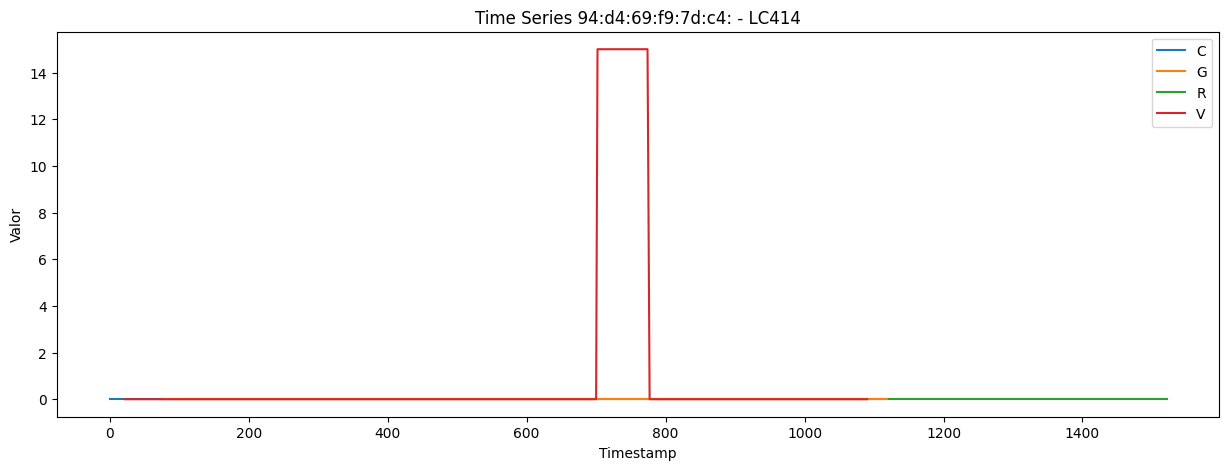

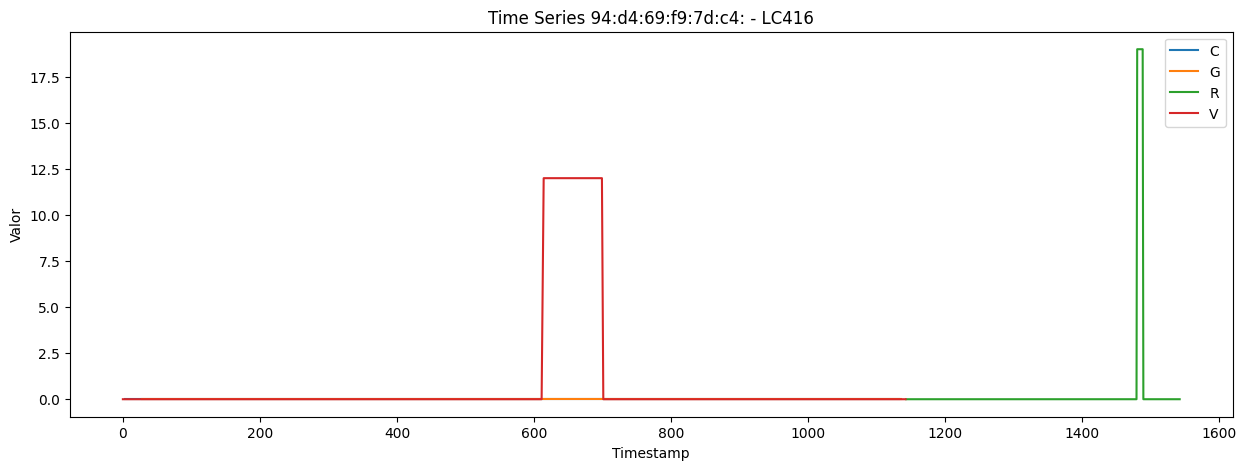

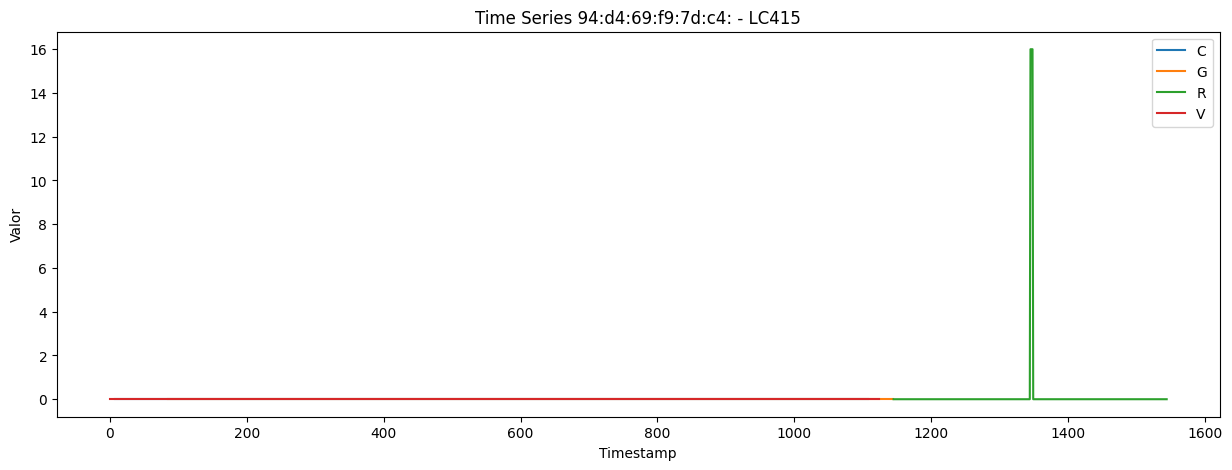

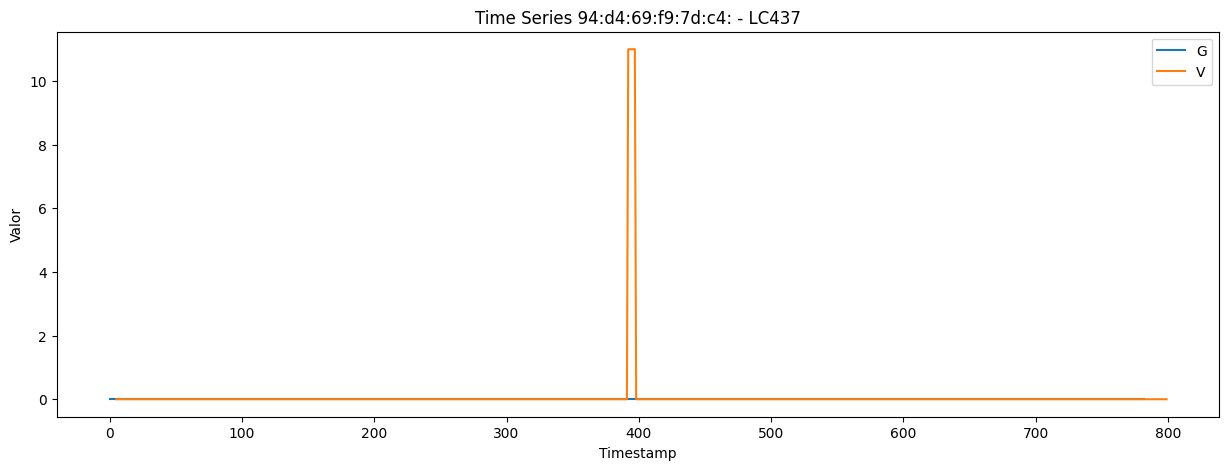

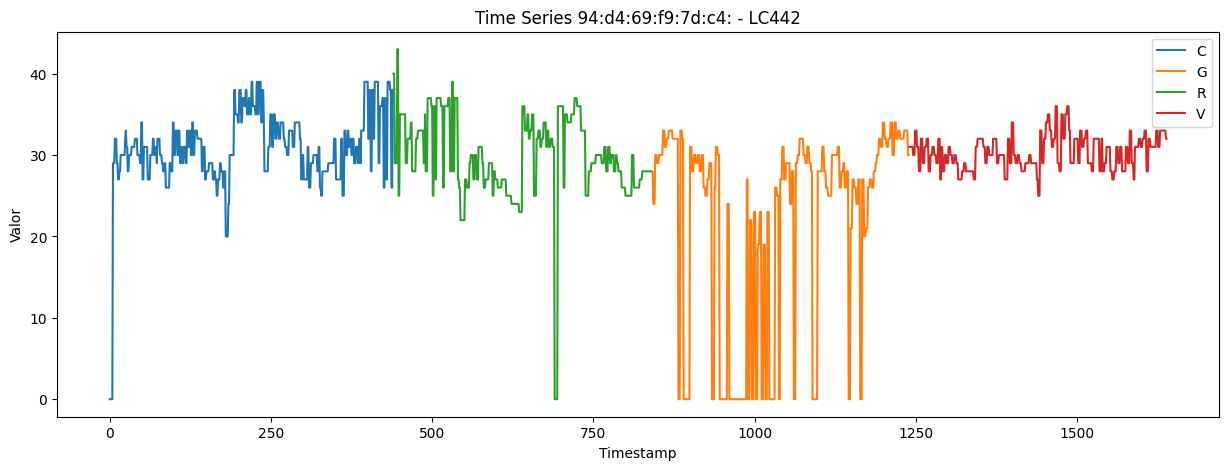

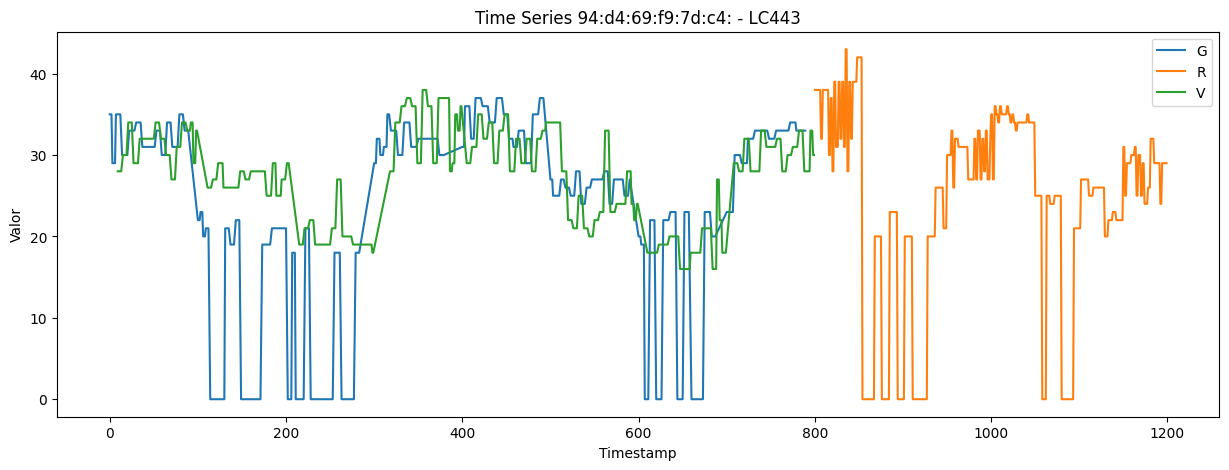

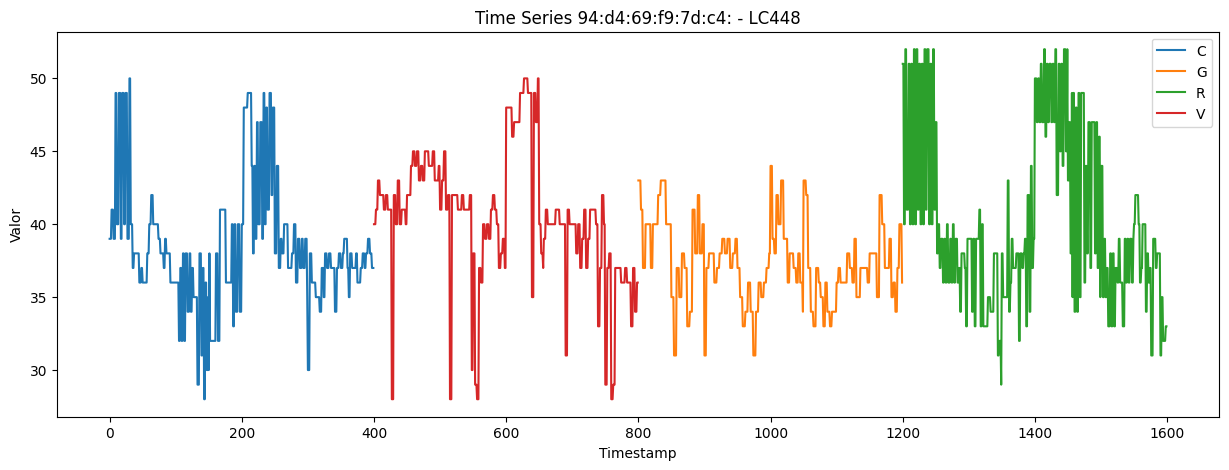

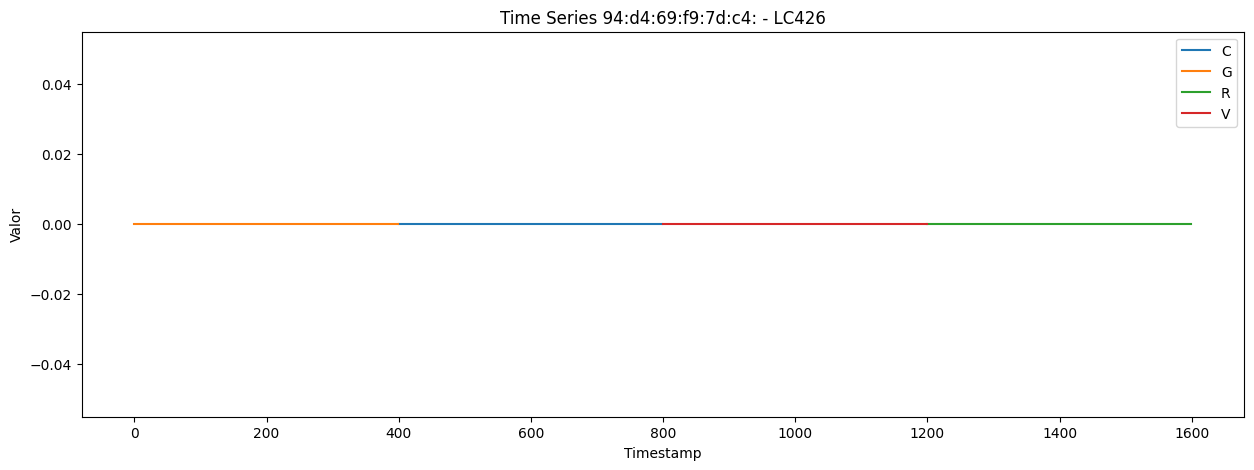

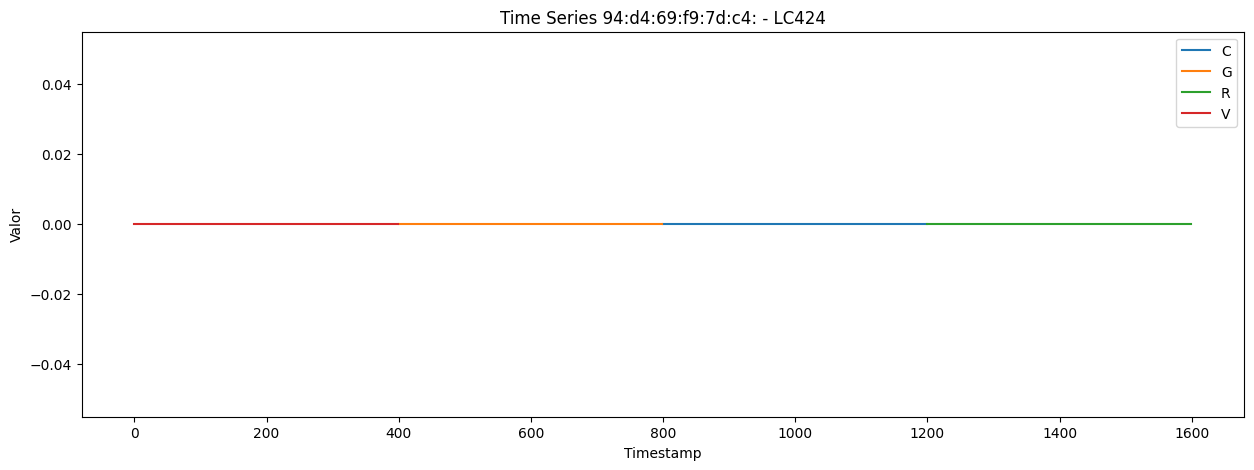

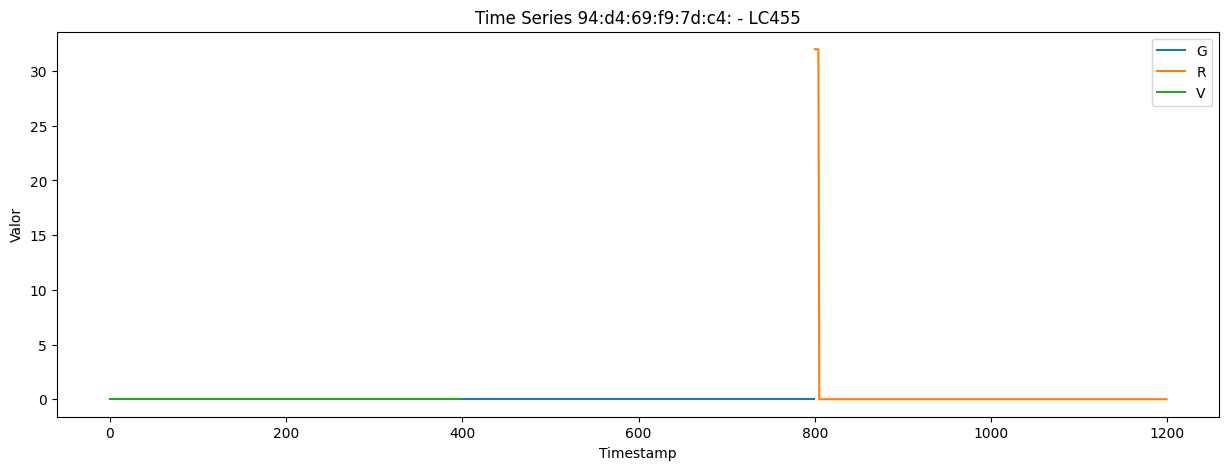

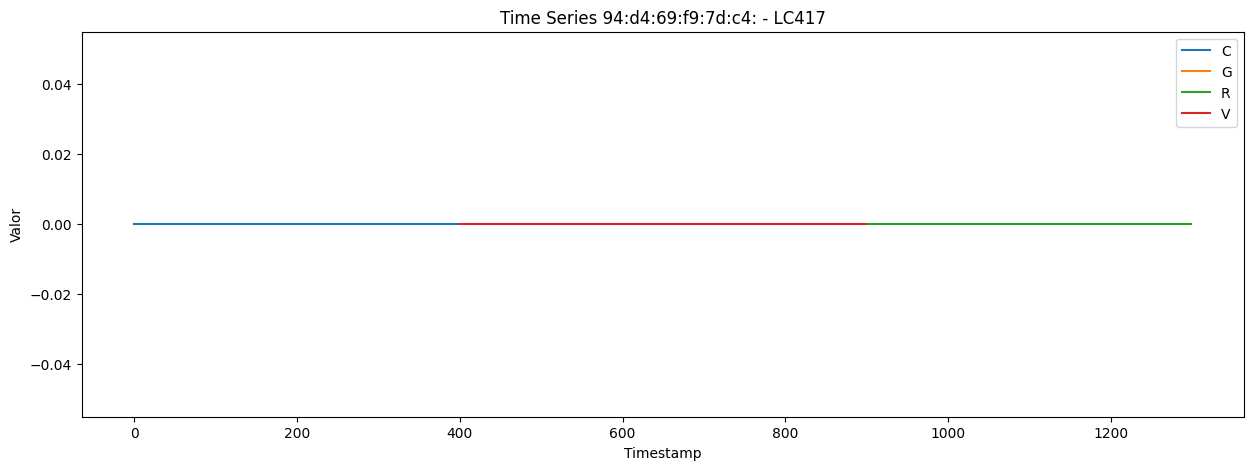

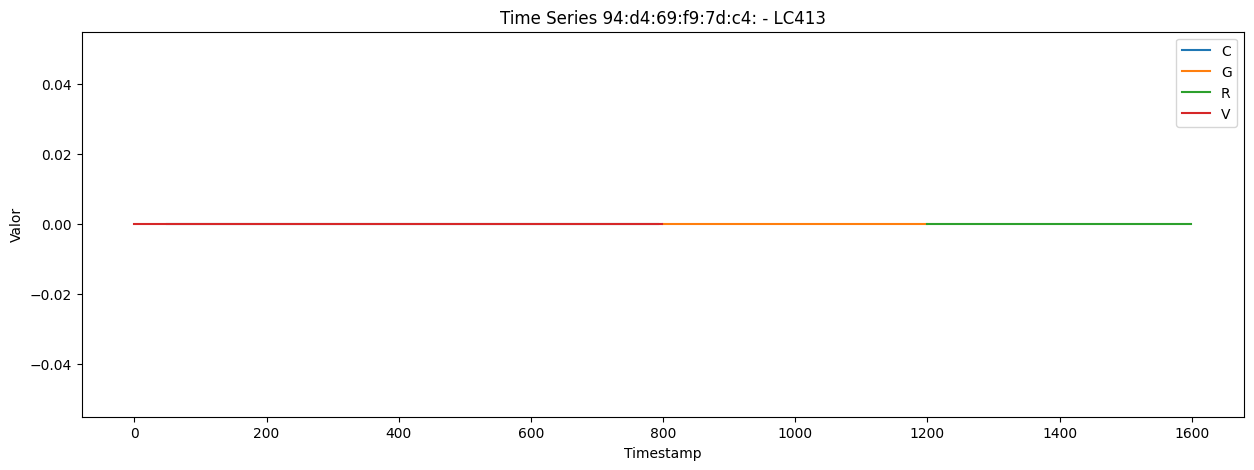

In [36]:

for room in rooms:
    plt.figure(figsize=(15, 5))

    data_of_ap_to_plot = data_of_ap[(data_of_ap["room"] == room)]
    data_of_ap_to_plot = data_of_ap_to_plot.sort_values(by='timestamp')
    data_of_ap_to_plot = data_of_ap_to_plot.reset_index()

    for label in np.unique(data_of_ap_to_plot["device_id"]):
        plt.plot(data_of_ap_to_plot[data_of_ap_to_plot["device_id"] == label].index,
                data_of_ap_to_plot[data_of_ap_to_plot["device_id"] == label][AP], label=label)

    plt.xlabel('Timestamp')
    plt.ylabel('Valor')
    plt.title(f'Time Series {AP} - {room}')
    plt.legend()
    plt.show()

        


# Filter

In [64]:
data_to_remove_outliers = data.groupby(["room", "room_part", "device_id"])

aux = []
for name, data_grouped in data_to_remove_outliers:
    data_grouped = data_grouped.reset_index()
    mean = data_grouped[AP_columns].mean()
    
    for ap in AP_columns:
        if mean[ap] > 5:
            for i in range(len(data_grouped)):
                if data_grouped.at[i, ap] == 0:
                    # Find the nearest non-zero value
                    nearest_non_zero = None
                    left_index = i - 1
                    right_index = i + 1
                    
                    while nearest_non_zero is None:
                        if left_index >= 0 and data_grouped.at[left_index, ap] != 0:
                            nearest_non_zero = data_grouped.at[left_index, ap]
                        elif right_index < len(data_grouped) and data_grouped.at[right_index, ap] != 0:
                            nearest_non_zero = data_grouped.at[right_index, ap]
                        else:
                            left_index -= 1
                            right_index += 1
                    
                    # Replace the zero value with the nearest non-zero value
                    data_grouped.at[i, ap] = nearest_non_zero

    aux.append(data_grouped)


data_filtered_without_outliers = pd.concat(aux, ignore_index=True)


    

In [74]:
data_to_filter = data_filtered_without_outliers.groupby(["room", "room_part", "device_id"])

aux = []
alpha = 0.5
for name, data_grouped in data_to_filter:
    # data_filtered.loc[len(data_filtered.index)] = data_grouped.iloc[0]
    filtered_values = data_grouped.iloc[0][AP_columns]
    for _, values in data_grouped.iterrows():
        filtered_values = alpha*values[AP_columns] + (1-alpha)*filtered_values
        # data_filtered.loc[len(data_filtered.index)] = list(values[non_AP_columns]) + list(filtered_values)
        aux.append(list(values[non_AP_columns]) + list(filtered_values))


data_filtered = pd.DataFrame(aux, columns=data.columns)

    

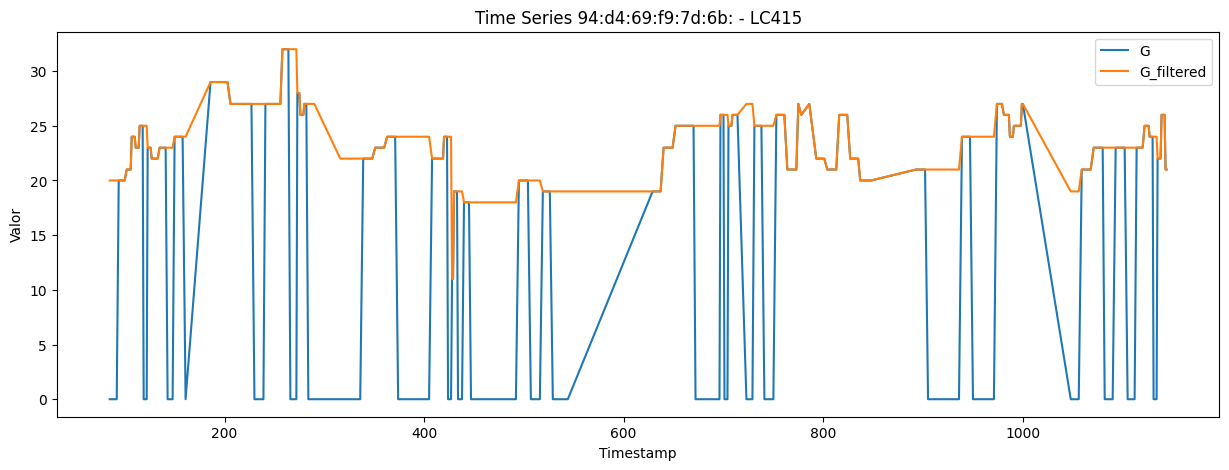

In [73]:
room = "LC415"
data_of_room_part = data[(data["room"] == room)]
data_of_room_part = data_of_room_part.sort_values(by='timestamp')
data_of_room_part = data_of_room_part.reset_index()

data_of_room_part2 = data_filtered_without_outliers[(data_filtered_without_outliers["room"] == room)]
data_of_room_part2 = data_of_room_part2.sort_values(by='timestamp')
data_of_room_part2 = data_of_room_part2.reset_index()

ap = aps_to_plot[2]
plt.figure(figsize=(15, 5))
plt.plot(data_of_room_part[data_of_room_part["device_id"] == "G"].index,
            data_of_room_part[data_of_room_part["device_id"] == "G"][ap], label="G")

plt.plot(data_of_room_part2[data_of_room_part2["device_id"] == "G"].index,
            data_of_room_part2[data_of_room_part2["device_id"] == "G"][ap], label="G_filtered")


plt.xlabel('Timestamp')
plt.ylabel('Valor')
plt.title(f'Time Series {"94:d4:69:f9:7d:6b:"} - {room}')
plt.legend()
plt.show()

In [82]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
train_data = data_filtered[data_filtered["device_id"] != "G"]
test_data = data_filtered[data_filtered["device_id"] == "G" ]
neigh = KNeighborsClassifier(n_neighbors=15, )
neigh.fit(train_data.iloc[:,5:], train_data['room'])
predicted = neigh.predict(test_data.iloc[:,5:])
ground_truth = test_data["room"].to_numpy()
np.sum(predicted == ground_truth)/len(ground_truth)


0.9979974513016566

In [83]:
train_data = data[data["device_id"] != "G"]
test_data = data[data["device_id"] == "G" ]
neigh = KNeighborsClassifier(n_neighbors=15, )
neigh.fit(train_data.iloc[:,5:], train_data['room'])
predicted = neigh.predict(test_data.iloc[:,5:])
ground_truth = test_data["room"].to_numpy()
np.sum(predicted == ground_truth)/len(ground_truth)


0.9885308574549426

In [84]:
from scipy.special import gamma
from scipy.special import hyp2f1

import scipy

class TLoc:         

    def __init__(self, train_data: pd.DataFrame):
        # self.non_null_minimum_percentage = 0.1
        self.train_data = train_data
        # self.aps = self.get_aps_with_non_zero_minimum_percentage(self.train_data)
        self.aps = list(self.train_data.columns[1:])
        if len(self.aps) == 1:
            self.max_power = int(self.train_data[self.aps].max())
        else:
            self.max_power = int(self.train_data[self.aps].max().max())


        self.spaces = list(self.train_data["room"].unique())

        self.power_probability_masks = {}
        self.power_prior_probability_distribution = {}
        self.eps = 1e-5


    def get_aps_with_non_zero_minimum_percentage(self, data):
        percentage_of_non_zeros = (data.iloc[:, 5:] != 0).sum() / data.shape[0]
        return data.columns[5:][percentage_of_non_zeros >= self.non_null_minimum_percentage]
    


    def get_mu_and_phi_estimation(self, data, router):
        mu = []
        phi = []
        data_of_router = data[["room", router]]
        for space in self.spaces:
            data_of_router_in_space = data_of_router[data_of_router["room"] == space]

            data_of_router_in_space_without_zero_values = data_of_router_in_space[data_of_router_in_space[router] != 0]
            if len(data_of_router_in_space_without_zero_values) == 0:
                mu.append(0.0)
            else:
                mu.append(data_of_router_in_space_without_zero_values[router].mean())
            phi.append(1 - data_of_router_in_space_without_zero_values.shape[0] / data_of_router_in_space.shape[0])

        return mu, phi



    def train(self):
        for router in self.aps:


            self.power_probability_masks[router] = {}
            self.power_prior_probability_distribution[router] = {}

            mu, phi = self.get_mu_and_phi_estimation(self.train_data, router)


            total_num_samples_in_router = self.train_data[router].shape[0]
            for power in range(0, self.max_power):
                self.power_probability_masks[router][
                    power] = self.approximate_position_density_function_given_router(power, np.array(mu),
                                                                                    np.array(phi))
                num_samples_with_value_power_in_router = (self.train_data[router] == power).sum()

                self.power_prior_probability_distribution[router][
                    power] = num_samples_with_value_power_in_router / total_num_samples_in_router

                    

    def cumulative_distribution_function_of_t_student(self, x, v):

        return 0.5 + x * gamma((v + 1) / 2) * hyp2f1(1 / 2, (v + 1) / 2, 3 / 2, -(x ** 2) / v) / (
                np.sqrt(v * np.pi) * gamma(v / 2))
    
    def cumulative_distribution_function_of_power(self, power, mu, phi, sigma, v):

        cdf = phi * np.heaviside(power, 1) + (1 - phi) * self.cumulative_distribution_function_of_t_student(
            (power - mu) / sigma, v)
        
        return cdf
    

    def approximate_position_density_function_given_router(self, power, mu, phi, sigma=5, num_samples_per_ap=30, t_score_alpha=0.05):

        v = np.ceil(num_samples_per_ap * (1 - phi) - 1)
        v = np.where(v <= 0, 1, v)

        t_score = scipy.stats.t.ppf(0.5 + t_score_alpha, v)

        density_function = self.cumulative_distribution_function_of_power(power + t_score * sigma, mu, phi, sigma, v) - self.cumulative_distribution_function_of_power(
                    power - t_score * sigma, mu, phi, sigma, v)  # power, mu, phi, sigma, v

        return density_function
    

    def pred(self, X_test):

        y_pred = []
        min_prob = self.eps * np.ones(len(self.spaces))

        for _, test_sample in X_test.iterrows():

            distribution_xy_given_bf = np.ones(len(self.spaces))

            for router in self.aps:

                    power = int(test_sample[router])

                    try:
                        prob_p_given_xybfr = self.power_probability_masks[router][power]
                    except KeyError:
                        # print(f"Error predicting router {router}, power {power}")
                        continue
                    


                    prob_p_given_xybfr = np.maximum(prob_p_given_xybfr, min_prob)
                    #prob_p_given_xybfr = prob_p_given_xybfr / prob_p_given_xybfr.sum()
                    #prob_xy_given_pbfr = prob_p_given_xybfr / (
                    #                tloc.eps + tloc.power_prior_probability_distribution[router][power])


                    distribution_xy_given_bf = distribution_xy_given_bf * prob_p_given_xybfr




            room_pred = self.spaces[distribution_xy_given_bf.argmax()]
            y_pred.append(room_pred)

        y_pred = np.array(y_pred)
        ground_truth = np.array(list(test_data["room"]))
        ac = np.sum(y_pred == ground_truth)/len(ground_truth)
        return ac, y_pred, ground_truth

In [96]:
train_data = data[data["device_id"] != "R"]
test_data = data[data["device_id"] == "R" ]

In [97]:
columns_to_train = [train_data.columns[1]] + list(train_data.columns[5:])

In [98]:

tloc = TLoc(train_data[columns_to_train])
tloc.train()

In [99]:
accuracy, prediction, ground_truth = tloc.pred(test_data)

In [100]:
accuracy

0.8915384615384615

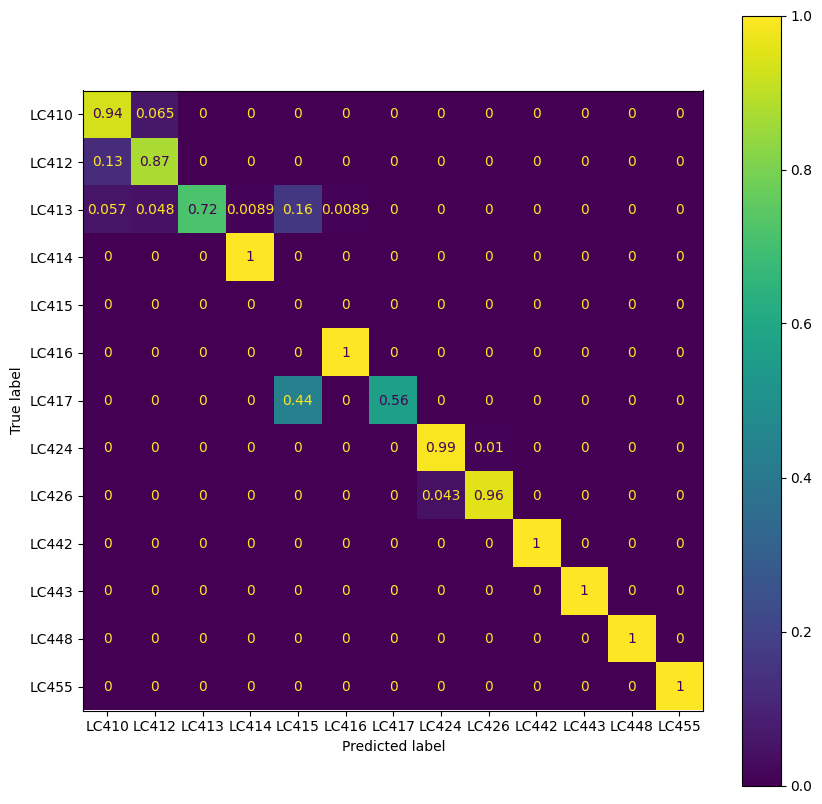

In [101]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10,10))
cmd = ConfusionMatrixDisplay(confusion_matrix(prediction, ground_truth, normalize='true'), display_labels=list(np.unique(ground_truth)))
cmd.plot(ax=ax)
plt.show()